### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input

%matplotlib inline

RANDOM_SEED =7124
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


In [2]:
# Reading the data and lookng at the structure of the data. This data has 30 attributes and 1 lakh records
data = pd.read_csv("Fraud_data_amtstd.csv")
data.shape

(100000, 30)

In [3]:
#Looking at a sample of records
data.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.836500,-0.545419,-0.462979,0.537174,-0.426143,-0.100606,-0.584764,-0.103956,2.268429,-0.365185,...,0.085111,0.410736,0.137625,0.602906,-0.350260,0.464407,-0.070917,-0.030486,0.049882,0
1,-4.289880,-2.576061,-0.092256,1.976405,2.810033,-2.669128,-0.981883,-0.470310,-0.025692,0.099528,...,-0.473240,-0.307295,-2.789549,0.578976,-0.837979,0.372843,0.353451,-1.662202,-0.347171,0
2,1.131318,0.139818,0.586921,1.069291,-0.334908,-0.204938,-0.135526,0.043821,-0.121117,0.182139,...,-0.028126,-0.167062,-0.048054,-0.009912,0.417694,-0.479793,0.024360,0.023878,-0.208963,0
3,-0.866956,1.373947,1.948343,2.686750,-0.366790,0.568632,-0.278349,0.739536,-1.655955,0.708396,...,0.022719,-0.070619,-0.080307,0.000816,0.092167,0.159131,0.157940,-0.014370,-0.253595,0
4,-0.842670,1.401843,0.927235,1.070402,0.843883,0.467333,0.366716,0.616739,-1.586963,0.000041,...,0.036573,-0.182581,-0.226834,-1.029794,-0.118762,-0.228960,-0.024250,0.046547,-0.346230,0


0    99508
1      492
Name: Class, dtype: int64


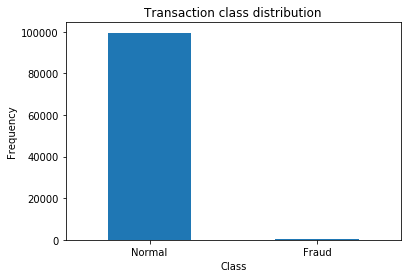

In [4]:
#PLotting the frequencies of fraud and non-fraud transactions in the data
count_classes = pd.value_counts(data['Class'], sort = True)
print(count_classes)

#Drawing a barplot
count_classes.plot(kind = 'bar', rot=0)

#Giving titles and labels to the plot
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [5]:
from sklearn.model_selection import train_test_split
#Converting data to array
data = np.array(data)

In [16]:
#Splitting the data into train and test and observing their dimensions
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
print(X_train.shape)
print(X_test.shape)

(80000, 30)
(20000, 30)


In [17]:
#Obtaining the fraud and non-fraud records in train
print(np.unique(X_train[:,29],return_counts=True))
print(np.unique(X_test[:,29],return_counts=True))

(array([ 0.,  1.]), array([79591,   409]))
(array([ 0.,  1.]), array([19917,    83]))


In [18]:
#Now consider only the non-fraud records for training
X_train_NF = X_train[X_train[:,-1] == 0]
X_train_NF = X_train_NF[:,:-1]
print(X_train_NF.shape)

(79591, 29)


In [19]:
#Separating out the fraud records from the train 
X_train_F = X_train[X_train[:,-1] == 1]
print(X_train_F.shape)

(409, 30)


In [20]:
#Adding/concatenating the fraud records from train data to the test
X_test=np.concatenate((X_test,X_train_F),axis=0)
print(X_test.shape)

(20409, 30)


In [21]:
X_test,X_eval = train_test_split(X_test, test_size=0.2, random_state=RANDOM_SEED)

In [22]:
print(X_test.shape)
print(X_eval.shape)

(16327, 30)
(4082, 30)


In [23]:
#Separating the independent and the class variable
y_test = X_test[:,-1]
X_test = X_test[:,:-1]
print(y_test.shape)

(16327,)


In [24]:
#Expanding the dimensions of y for later concatenation
y_test = np.expand_dims(y_test, axis=1)
y_test.shape

(16327, 1)

#### Model Building

In [25]:
print(X_train_NF.shape)

(79591, 29)


In [26]:
input_dim = X_train_NF.shape[1]
encoding_dim = 15

### 'Model' API in keras

In [106]:
inp = Input(shape=(input_dim,))
dp = Dropout(0.2)(inp)
encoded = Dense(encoding_dim, activation='relu')(dp)
decoded = Dense(input_dim, activation='linear')(encoded)

encoder = Model(inp, encoded)
autoencoder = Model(inp, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [107]:
hist_model = autoencoder.fit(X_train_NF, X_train_NF,
                         epochs=2,
                         batch_size=batch_size,
                         validation_split=0.3,
                         verbose=1).history

train_encodings = encoder.predict(X_train_NF)
print(train_encodings.shape)

Train on 55713 samples, validate on 23878 samples
Epoch 1/2
55713/55713 [==============================] - 4s 73us/step - loss: 0.7131 - val_loss: 0.3603
Epoch 2/2
55713/55713 [==============================] - 4s 64us/step - loss: 0.4147 - val_loss: 0.2607


In [114]:
decoder_inp = Input(shape=(encoding_dim,))
decoded2 = Dense(input_dim, activation='linear')(decoder_inp)
decoder = Model(decoder_inp, decoded2)
decoder.layers[1].set_weights(autoencoder.layers[3].get_weights())
decoded_train = decoder.predict(train_encodings)
print(decoded_train.shape)

### 'Sequential' API in Keras

In [121]:
from keras.layers import BatchNormalization, Activation

In [122]:
autoencoder = Sequential()

autoencoder.add(Dropout(0.2, input_shape=(input_dim,)))
autoencoder.add(Dense(encoding_dim))
autoencoder.add(BatchNormalization())
autoencoder.add(Activation('relu'))
autoencoder.add(Dense(input_dim, activation='linear'))

In [123]:
autoencoder.layers

In [31]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error')

In [33]:
hist = []
for _ in range(nb_epoch):
    hist.append(autoencoder.fit(X_train_NF, X_train_NF,
                    epochs=1,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.3,
                    verbose=1).history)

Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 4s 66us/step - loss: 0.7320 - val_loss: 0.3831
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 3s 59us/step - loss: 0.4183 - val_loss: 0.2701
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 3s 59us/step - loss: 0.3693 - val_loss: 0.2426
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 3s 59us/step - loss: 0.3564 - val_loss: 0.2366
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 3s 60us/step - loss: 0.3545 - val_loss: 0.2321
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 3s 63us/step - loss: 0.3511 - val_loss: 0.2287
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [===

55713/55713 [==============================] - 3s 62us/step - loss: 0.3234 - val_loss: 0.2272
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 4s 70us/step - loss: 0.3303 - val_loss: 0.2256
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 3s 59us/step - loss: 0.3241 - val_loss: 0.2271
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 4s 63us/step - loss: 0.3241 - val_loss: 0.2262
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 3s 58us/step - loss: 0.3256 - val_loss: 0.2250
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 3s 59us/step - loss: 0.3278 - val_loss: 0.2236
Train on 55713 samples, validate on 23878 samples
Epoch 1/1
55713/55713 [==============================] - 3s 58us/step - loss: 0.3279 -

In [34]:
hist[0:5]

[{'loss': [0.73201568548162566], 'val_loss': [0.3830600043958291]},
 {'loss': [0.4182975922471463], 'val_loss': [0.27008753243014083]},
 {'loss': [0.36930694400910069], 'val_loss': [0.24256646833219903]},
 {'loss': [0.35635886061527067], 'val_loss': [0.23656362066622186]},
 {'loss': [0.35450916402574834], 'val_loss': [0.23210380488538754]}]

In [35]:
## Making predictions on the train data
predictions=autoencoder.predict(X_train_NF)

In [36]:
predictions[0:2]

array([[-1.57508397,  0.89191043,  1.8274318 ,  0.88308305, -0.82059121,
         0.50705552, -0.54883134,  1.13653231,  0.4838143 , -0.80707431,
        -1.30298352,  0.32980907, -1.00957537, -0.26834917, -1.80746865,
        -0.44764772,  0.55764008, -0.07484169,  0.2117385 ,  0.03960407,
        -0.0131715 ,  0.01895072, -0.03133155, -0.02361332,  0.01948734,
         0.03855105,  0.05796118,  0.05118264, -0.1899952 ],
       [ 1.29190099, -0.31356555,  0.01293969, -0.39256564, -0.65626287,
        -1.47212481, -0.07580352, -0.30364195, -1.08132601,  0.66609311,
         0.22819209, -0.0716064 ,  0.43708789, -0.1979624 ,  0.1413472 ,
         0.01295978,  0.10234129,  0.0309182 , -0.0570012 , -0.04102144,
        -0.01259482,  0.00855413, -0.01214901, -0.0193859 , -0.03495473,
        -0.00583411, -0.0071388 ,  0.03221527, -0.16305463]], dtype=float32)

In [38]:
##We want to separate out fraud records and non-fraud records for later use
f = np.hstack((X_test,y_test))
print(f.shape)

test_nf=f[f[:,29]==0]
print(test_nf.shape)

test_f=f[f[:,29]==1]
print(test_f.shape)

(16327, 30)
(15942, 30)
(385, 30)


In [39]:
#Getting the errors from the non fraud data separately 
autoencoder.evaluate(test_nf[:,:29],test_nf[:,:29])

15942/15942 [==============================] - 0s 27us/step


0.2299939538596969

In [40]:
#Getting the errors from the fraud data separately
autoencoder.evaluate(test_f[:,:29],test_f[:,:29])

385/385 [==============================] - 0s 48us/step


19.31717576732883

In [41]:
#Obtaining predictions for non fraud records
predictions_nf=autoencoder.predict(test_nf[:,:29])

In [42]:
#Obtaining predictions for fraud records
predictions_f=autoencoder.predict(test_f[:,:29])

In [46]:
#Identifying the error computation method by autoencoder(Mean Squared Error). The computation is as follows 
we = np.mean(np.square(np.abs(test_nf[:,:29]-predictions_nf)))
print(we)
print(we.shape)

0.229993953187
()


In [47]:
#Computing errors on the non-fraud data
errors_nf = np.mean(np.square(np.abs(test_nf[:,:29]-predictions_nf)), axis=1)
print(errors_nf.shape)

(15942,)


In [48]:
errors_nf[0:5]

array([ 0.33061262,  0.06878617,  0.20113485,  0.07069329,  0.30208894])

In [49]:
#Computing errors on the fraud data
errors_f = np.mean(np.square(np.abs(test_f[:,:29]-predictions_f)), axis=1)

In [50]:
errors_f[0:5]

array([ 88.52762484,  72.84247898,  17.6531336 ,   4.04507093,  69.47013287])

In [52]:
#Computing the distribution of errors in both non-fraud and fraud data
print(np.min(errors_nf))
print(np.max(errors_nf))
print(np.median(errors_nf))

print('\n')
print(np.min(errors_f))
print(np.max(errors_f))
print(np.median(errors_f))

0.0136010214749
108.636262322
0.123301562292


0.0464575760104
135.26000345
7.99399046241


{'boxes': [<matplotlib.lines.Line2D at 0x133a0b710>],
 'caps': [<matplotlib.lines.Line2D at 0x133744160>,
 'fliers': [<matplotlib.lines.Line2D at 0x133744dd8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1337449b0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x133a0b860>,
  <matplotlib.lines.Line2D at 0x133a0bcf8>]}

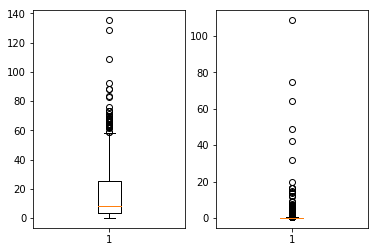

In [53]:
#PLotting the error box plots 

plt.subplot(1, 2,1)
plt.boxplot(errors_f)

plt.subplot(1, 2, 2)
plt.boxplot(errors_nf)

In [54]:
#Experimentation to fix a threshold for classification of a transaction into fraud or non-fraud
print(sum(errors_nf>np.median(errors_f)))
print(sum(errors_f<np.median(errors_f)))
print(sum(errors_f<np.median(errors_nf)))
sum(errors_nf>np.median(errors_nf))

18
192
13


7971

In [56]:
print(errors_nf.shape)
print(errors_f.shape)

(15942,)
(385,)


In [57]:
print(predictions_nf.shape)
print(predictions_f.shape)

(15942, 29)
(385, 29)


In [58]:
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix

In [59]:
test_pred = autoencoder.predict(X_test[:,:29])
test_recon  = (((test_pred-X_test)**2).mean(-1))

train_pred = autoencoder.predict(X_train_NF[:,:29])
mean_recon = (((train_pred - X_train_NF)**2).mean(-1).mean())

scores_f1 = []
thres = []

th = 0
for i in range(100):
    th+=0.1
    fraud = (test_recon>mean_recon+th)
    scores_f1.append(f1_score(y_test,fraud))
    thres.append(th+mean_recon)
    

In [60]:
X_test.shape

(16327, 29)

In [65]:
print(np.argmax(scores_f1))
print(thres[25])

25
2.82594102573


2.82594102573


array([[15874,    68],
       [   88,   297]])

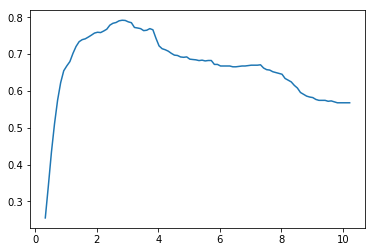

In [66]:
plt.plot(thres, scores_f1)

print(thres[np.array(scores_f1).argmax()])

fraud = (test_recon>thres[np.array(scores_f1).argmax()])

confusion_matrix(y_test, fraud)

In [42]:
##Predicting on Valdation 

predictions_eval=autoencoder.predict(X_eval[:,:29])


In [43]:
errors_eval=np.square(np.subtract(predictions_eval,X_eval[:,:29]))

In [44]:
fraud_eval=(((errors_eval-X_eval[:,:29])**2).mean(-1))>2.925861360803925

In [45]:
print(confusion_matrix(y_true=X_eval[:,29],y_pred=fraud_eval))

[[3682  293]
 [  15   92]]


### Analysis on individual attribute errors

In [69]:
#Obtaining errors on individual attributes on non-fraud data
ind_errors_nf=np.abs(np.subtract(predictions_nf,test_nf[:,:29]))
print(ind_errors_nf.shape)

(15942, 29)


In [70]:
#Obtaining errors on individual attributes on fraud data
ind_errors_f=np.abs(np.subtract(predictions_f,test_f[:,:29]))
print(ind_errors_f.shape)

(385, 29)


#### To check the errors on fraud and non-fraud data across all the attributes

In [80]:
#Combining all fraud and non-fraud data errors
X=np.concatenate((ind_errors_f,ind_errors_nf),axis=0)
print(X.shape)

(16327, 29)


In [81]:
#Creating a target column
x=np.array([1,0])
Y=np.repeat(x,[385,15942])

In [82]:
#Expanding the shape of the target for merging with all other attributes
print(Y.shape)
Y = np.expand_dims(Y, axis=1)
print(Y.shape)

(16327,)
(16327, 1)


In [83]:
#Concatenating all the attribute errors with target class
X=np.concatenate((X,Y),axis=1)
print(X.shape)

(16327, 30)


In [84]:
map(str,range(X.shape[1]))

In [85]:
#Creating a data frame and naming the columns
X=pd.DataFrame(X)
X.columns = map(str, range(X.shape[1]))

In [86]:
#Melting the data for box plot visualization
M = pd.melt(X, "29", var_name="var", value_name="value")
M['29'].astype('category')
M.tail()
#M.head()

,29,var,value
473478,0.0,28,0.067193
473479,0.0,28,0.062815
473480,0.0,28,0.131629
473481,0.0,28,0.060594
473482,0.0,28,0.120219


#### Plotting the errors of fraud and non-fraud transactions across attributes

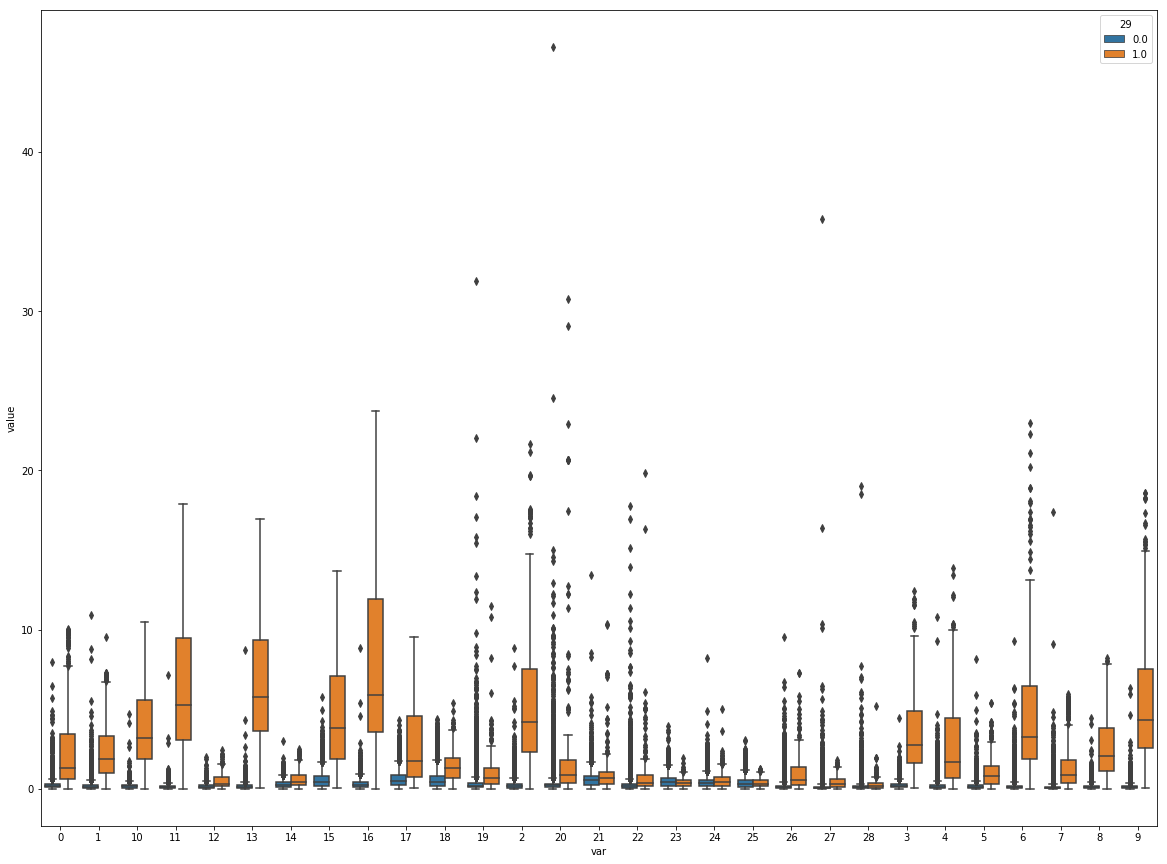

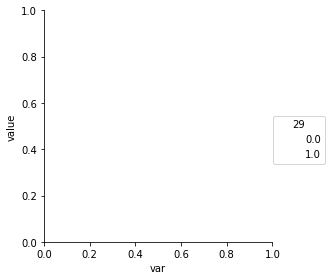

In [87]:
import seaborn as sns
size=(20,15)
fig,ax = plt.subplots(figsize=size)
# the size of A4 paper
sns.factorplot(x="var", y='value', hue="29", data=M, kind='box',ax=ax)

#### Looking at the box plots it is evident that there is a huge difference in errors of fraud and non-fraud  in attributes 10,11,13,16,and 2. Observing errors only on those attributes

In [56]:
pred_nf=ind_errors_nf[:,[10,11,13,16,2]]
np.mean(pred_nf,axis=0)

array([0.1741741 , 0.1274215 , 0.14511604, 0.35220956, 0.22013431])

In [57]:
pred_f=ind_errors_f[:,[9,10,11,13,16]]
np.mean(pred_f,axis=0)

array([4.84821485, 3.55451769, 6.53944442, 6.74798986, 7.79435993])

#### Looking at the percentile distribution of errors

In [58]:
#Percentile distribution of absolute errors
percentile_nf=np.percentile(ind_errors_nf[:,[10,11,13,16,2]],[10,20,30,40,50,60,70,80,90,100],axis=0)

In [59]:
percentile_nf

array([[0.02761223, 0.01810327, 0.02117655, 0.04991286, 0.02916316],
       [0.05611028, 0.03673301, 0.04233438, 0.10008467, 0.05782372],
       [0.08479168, 0.05598823, 0.06368077, 0.15414321, 0.08966023],
       [0.11667421, 0.07671513, 0.08519819, 0.21086195, 0.12386638],
       [0.15295604, 0.09954615, 0.10810438, 0.27463088, 0.16626234],
       [0.18950027, 0.12512066, 0.13547445, 0.34599454, 0.21196903],
       [0.22760439, 0.15653117, 0.16915801, 0.43540688, 0.2612301 ],
       [0.27365994, 0.19549676, 0.21507189, 0.54967711, 0.32751202],
       [0.3376126 , 0.26378131, 0.29559329, 0.73515174, 0.4375467 ],
       [3.81947005, 7.44698859, 8.96685406, 9.27005355, 9.29015539]])

In [60]:
percentile_nf[:,3]

array([0.04991286, 0.10008467, 0.15414321, 0.21086195, 0.27463088,
       0.34599454, 0.43540688, 0.54967711, 0.73515174, 9.27005355])

In [61]:
percentile_f=np.percentile(ind_errors_f[:,[10,11,13,16,2]],[10,20,30,40,50,60,70,80,90,100],axis=0)

In [62]:
percentile_f[:,3]

array([ 0.48758049,  1.93609385,  4.01939127,  4.76651809,  5.83414349,
        7.38052427,  9.41749048, 15.15943929, 17.64224459, 23.58938624])

#### For 16th arrtibute,  the 20th percentile error on fraud is 1.44 and less than 10 percent of the values from non-fraud exist above this value. Setting this as the threshold for fraud classification

In [66]:
thr=1.93
test_pred = autoencoder.predict(X_test)

In [64]:
recon_error= np.abs(np.subtract(test_pred,X_test[:,:29]))

In [65]:
recon_error.shape

(16327, 29)

In [67]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,confusion_matrix
fraud = (recon_error[:,16]>1.93)
print(recall_score(y_test,fraud))
print(precision_score(y_test,fraud))
print(accuracy_score(y_test,fraud))

0.8
0.927710843373494
0.9938139278495743


In [68]:
print(confusion_matrix(y_true=y_test,y_pred=fraud))

[[15918    24]
 [   77   308]]


#### Testing on evaluation data

In [69]:
predictions_eval=autoencoder.predict(X_eval[:,:29])

In [70]:
ind_errors_eval=np.abs(np.subtract(predictions_eval,X_eval[:,:29]))

In [71]:
fraud_eval=ind_errors_eval[:,16]>1.93
print(recall_score(X_eval[:,29],fraud_eval))
print(precision_score(X_eval[:,29],fraud_eval))
print(accuracy_score(X_eval[:,29],fraud_eval))
print(f1_score(X_eval[:,29],fraud_eval))

0.8317757009345794
0.9368421052631579
0.9941205291523763
0.8811881188118812


In [72]:
print(confusion_matrix(y_true=X_eval[:,29],y_pred=fraud_eval))

[[3969    6]
 [  18   89]]
